# Train and eval models

## Load dataset

In [39]:
import matplotlib.pyplot as plt
import itertools
from collections import Counter, OrderedDict
from pprint import pprint

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [41]:
import torch
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DefaultDataCollator,
    Trainer,
    TrainingArguments
)

In [42]:
dataset_id = "ag_news"
dataset = load_dataset(dataset_id)
dataset

Using custom data configuration default
Reusing dataset ag_news (/Users/emiliomarinone/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

Since the dataset does not have an eval split, we generate it from the training set

In [43]:
split_train_ds = dataset["train"].train_test_split(test_size=0.1, seed=42)
dataset = DatasetDict({
    "train": split_train_ds["train"],
    "eval": split_train_ds["test"],
    "test": dataset["test"]
})
dataset

Loading cached split indices for dataset at /Users/emiliomarinone/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-a83c7d61fb1af540.arrow and /Users/emiliomarinone/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-e6ec95f998f1a335.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 108000
    })
    eval: Dataset({
        features: ['text', 'label'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [44]:
label_class = dataset["train"].features["label"]
label_names = label_class.names
num_labels = label_class.num_classes
print(f"{num_labels} labels: {label_names}")

4 labels: ['World', 'Sports', 'Business', 'Sci/Tech']


In [45]:
label_class

ClassLabel(num_classes=4, names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None)

In [46]:
encoded_intents = {k: v for v, k in enumerate(label_names)}
inverse_encoded_intents = {k: v for v, k in encoded_intents.items()}

In [47]:
encoded_intents

{'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}

In [48]:
inverse_encoded_intents

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

## Quick check to verify the dataset is not corrupted

In [49]:
dataset.set_format(type="pandas")

In [50]:
train_df = dataset["train"][:]
train_df["label_name"] = train_df["label"].apply(label_class.int2str)

In [51]:
test_df = dataset["test"][:]
test_df["label_name"] = test_df["label"].apply(label_class.int2str)

In [52]:
train_df.sample(5)

,text,label,label_name
35745,UPDATE: Australia #39;s WMC Ups Stakes In Xstr...,2,Business
1123,Monday #39;s AL Capsules Bruce Chen pitched hi...,1,Sports
8703,Intel test chip boasts technology to add to sp...,3,Sci/Tech
25464,NBA snubs hearing with arbitrator Ron Artest t...,1,Sports
52586,Users say Microsoft's Money is broke Glitches ...,3,Sci/Tech


In [53]:
test_df.sample(5)

,text,label,label_name
1406,Trying to recapture glory days With two Super ...,1,Sports
3315,Analysis: Iran #39;s missile capabilities Iran...,0,World
5641,Final respects paid to Arafat Palestinians pay...,0,World
2956,"Bush, Kerry Trade Barbs Following Debate ALLEN...",0,World
7126,"Napster Mobile December 10, 2004 - Remember Na...",3,Sci/Tech


In [54]:
train_df["label_name"].value_counts()

Business    27100
World       26991
Sports      26966
Sci/Tech    26943
Name: label_name, dtype: int64

In [55]:
test_df["label_name"].value_counts()

Business    1900
Sci/Tech    1900
Sports      1900
World       1900
Name: label_name, dtype: int64

In [56]:
dataset.reset_format()

## Split and tokenize dataset

In [57]:
model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [112]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [113]:
tokenized_dataset = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /Users/emiliomarinone/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-a86504b77b685c7c.arrow
Loading cached processed dataset at /Users/emiliomarinone/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-cb0c14d5a00f31f1.arrow


In [114]:
# tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [115]:
tokenized_dataset["train"][0]

{'text': 'Despair and Anger in Small Russian Town After Siege  BESLAN, Russia (Reuters) - The killing of more than 320  children, parents and teachers during the bloody end to a  53-hour school siege left barely a family untouched in the  small Russian town of Beslan.',
 'label': 0,
 'input_ids': [101,
  13905,
  1998,
  4963,
  1999,
  2235,
  2845,
  2237,
  2044,
  6859,
  2022,
  14540,
  2319,
  1010,
  3607,
  1006,
  26665,
  1007,
  1011,
  1996,
  4288,
  1997,
  2062,
  2084,
  13710,
  2336,
  1010,
  3008,
  1998,
  5089,
  2076,
  1996,
  6703,
  2203,
  2000,
  1037,
  5187,
  1011,
  3178,
  2082,
  6859,
  2187,
  4510,
  1037,
  2155,
  22154,
  1999,
  1996,
  2235,
  2845,
  2237,
  1997,
  2022,
  14540,
  2319,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [116]:
tokenized_dataset["test"][0]

{'text': "Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.",
 'label': 2,
 'input_ids': [101,
  10069,
  2005,
  1056,
  1050,
  11550,
  2044,
  7566,
  9209,
  5052,
  3667,
  2012,
  6769,
  2047,
  8095,
  2360,
  2027,
  2024,
  1005,
  9364,
  1005,
  2044,
  7566,
  2007,
  16654,
  6687,
  3813,
  2976,
  9587,
  24848,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

## Define metrics functions

In [117]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

In [118]:
def plot_confusion_matrix(y_true, y_pred, labels):
    # compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(len(labels),len(labels)))
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display.plot(cmap="Greens", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
    print(cm)
    return cm

In [209]:
y_true = [1]*50 + [0]*50
y_pred = [1]*40 + [0]*60

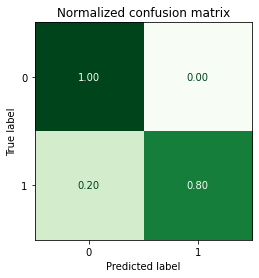

[[1.  0. ]
 [0.2 0.8]]


In [213]:
cm = plot_confusion_matrix(y_true, y_pred, labels=["0", "1"])

In [121]:
precision_recall_fscore_support(y_true, y_pred)

(array([0.83333333, 1.        ]),
 array([1. , 0.8]),
 array([0.90909091, 0.88888889]),
 array([50, 50]))

In [122]:
def plot_prfs(y_true, y_pred, labels):
    # fig, ax = plt.subplots(figsize=(4, len(labels)))
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

    prfs = precision_recall_fscore_support(y_true, y_pred)
    plt.table(
        cellText=prfs,
        rowLabels=["Precision", "Recall", "F1", "Support"],
        cellLoc="left",
        colLabels=labels,
        colWidths = [.3]*len(prfs[0]),
        loc="center",
        cellColours=plt.cm.hot(prfs),
        bbox=None
    )
    # display.plot(cmap="Greens", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Precision, recall, f1 score, true labels per class")
    plt.show()
    return prfs

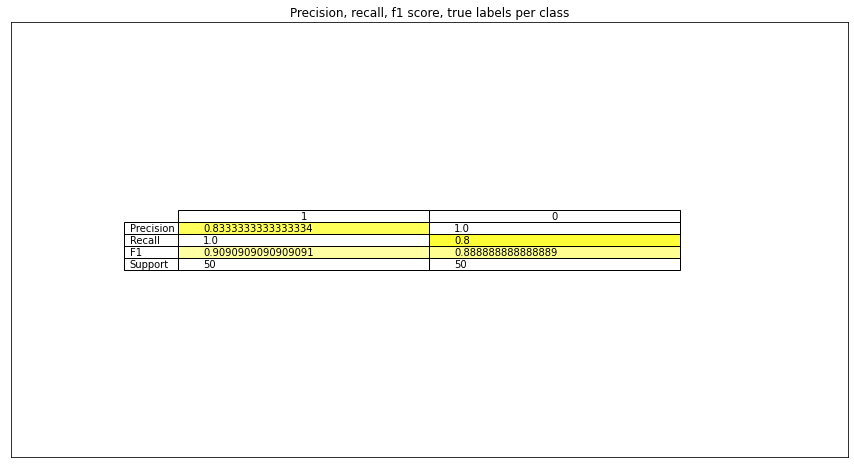

In [123]:
prfs = plot_prfs(y_true, y_pred, labels=["1", "0"])

In [140]:
# For training loop
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    return {"f1": f1_score(labels, preds, average="weighted")}

## Training

In [125]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [126]:
config = AutoModelForSequenceClassification.from_pretrained(model_id)
config

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/emiliomarinone/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [127]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=encoded_intents,
    id2label=inverse_encoded_intents
)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/emiliomarinone/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "World",
    "1": "Sports",
    "2": "Business",
    "3": "Sci/Tech"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Business": 2,
    "Sci/Tech": 3,
    "Sports": 1,
    "World": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "po

In [128]:
state_dict = model.state_dict()

In [129]:
type(state_dict)

collections.OrderedDict

In [130]:
state_dict.keys()

odict_keys(['bert.embeddings.position_ids', 'bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.weigh

In [131]:
for key, values in state_dict.items():
    print(values.shape)
    break

torch.Size([1, 512])


In [132]:
means = []
stds = []
maxs = []
mins = []

keys_split = OrderedDict()
for key, value in state_dict.items():
    key_dot_split = key.split(".")
    if key_dot_split[1] == "embeddings":
        split_key = "embeddings"
    
    elif key_dot_split[1] == "encoder":
        # eg: key == "bert.encoder.layer.0.attention.self.query.weight"
        # ->: split_key == "econder_layer_0"
        split_key = "_".join(key_dot_split[1:4])
    
    elif key_dot_split[1] == "pooler":
        split_key = "pooler"
    
    elif key_dot_split[0] == "classifier":
        split_key = "classifier"
    
    else:
        raise ValueError(f"Unexpected key: {key}")
    
    value = value.to(torch.float)
    # here value from 0 to embedding dim - 1 
    if key.endswith("position_ids"):
        mean = 0
        std = 0
        max_ = 0
        min_ = 0
    else:
        mean = torch.mean(torch.flatten(value))
        std = torch.std(value)
        max_ = torch.max(value)
        min_ = torch.min(value)
        means.append(mean)
        stds.append(std)
        maxs.append(max_)
        mins.append(min_)
        
    tuple_ = (key, value.shape, max_, min_, mean, std)
    try:
        keys_split[split_key].append(tuple_)
        
    except KeyError:
        keys_split[split_key] = [tuple_]

In [133]:
def print_model_info_dict(obj):
    for key, value in obj.items():
        print(key)
        pprint(value)
        print("\n" + "="*50 + "\n")

print_model_info_dict(keys_split)

embeddings
[('bert.embeddings.position_ids', torch.Size([1, 512]), 0, 0, 0, 0),
 ('bert.embeddings.word_embeddings.weight',
  torch.Size([30522, 768]),
  tensor(0.8729),
  tensor(-0.9504),
  tensor(-0.0280),
  tensor(0.0427)),
 ('bert.embeddings.position_embeddings.weight',
  torch.Size([512, 768]),
  tensor(0.7269),
  tensor(-0.9487),
  tensor(-3.8740e-05),
  tensor(0.0161)),
 ('bert.embeddings.token_type_embeddings.weight',
  torch.Size([2, 768]),
  tensor(0.2973),
  tensor(-0.6952),
  tensor(-0.0009),
  tensor(0.0336)),
 ('bert.embeddings.LayerNorm.weight',
  torch.Size([768]),
  tensor(0.9831),
  tensor(0.0893),
  tensor(0.8493),
  tensor(0.1340)),
 ('bert.embeddings.LayerNorm.bias',
  torch.Size([768]),
  tensor(0.8021),
  tensor(-0.5555),
  tensor(-0.0196),
  tensor(0.0693))]


encoder_layer_0
[('bert.encoder.layer.0.attention.self.query.weight',
  torch.Size([768, 768]),
  tensor(0.4541),
  tensor(-0.5249),
  tensor(3.5584e-05),
  tensor(0.0431)),
 ('bert.encoder.layer.0.attenti

[('bert.encoder.layer.8.attention.self.query.weight',
  torch.Size([768, 768]),
  tensor(0.3501),
  tensor(-0.3796),
  tensor(0.0001),
  tensor(0.0440)),
 ('bert.encoder.layer.8.attention.self.query.bias',
  torch.Size([768]),
  tensor(0.7405),
  tensor(-0.6898),
  tensor(-0.0089),
  tensor(0.1745)),
 ('bert.encoder.layer.8.attention.self.key.weight',
  torch.Size([768, 768]),
  tensor(0.3841),
  tensor(-0.4017),
  tensor(-4.2690e-05),
  tensor(0.0441)),
 ('bert.encoder.layer.8.attention.self.key.bias',
  torch.Size([768]),
  tensor(0.0253),
  tensor(-0.0181),
  tensor(0.0002),
  tensor(0.0067)),
 ('bert.encoder.layer.8.attention.self.value.weight',
  torch.Size([768, 768]),
  tensor(0.1778),
  tensor(-0.1872),
  tensor(9.5409e-06),
  tensor(0.0354)),
 ('bert.encoder.layer.8.attention.self.value.bias',
  torch.Size([768]),
  tensor(0.2395),
  tensor(-0.4492),
  tensor(-0.0006),
  tensor(0.0443)),
 ('bert.encoder.layer.8.attention.output.dense.weight',
  torch.Size([768, 768]),
  tensor

In [134]:
def max_min_mean_std(obj, name=""):
    print("Stats: ", name)
    print("Mean: ", torch.mean(torch.Tensor(obj)))
    print("Std: ", torch.std(torch.Tensor(obj)))
    print("Max: ", torch.max(torch.Tensor(obj)))
    print("Min: ", torch.min(torch.Tensor(obj)))
    print("\n" + "="*50 + "\n")

# They exclude values from embedding_ids € [0,512)
max_min_mean_std(means, name="mean")
max_min_mean_std(stds, name="std")
max_min_mean_std(maxs, name="max")
max_min_mean_std(mins, name="min")

Stats:  mean
Mean:  tensor(0.0941)
Std:  tensor(0.2802)
Max:  tensor(0.9585)
Min:  tensor(-0.1081)


Stats:  std
Mean:  tensor(0.0619)
Std:  tensor(0.0486)
Max:  tensor(0.3292)
Min:  tensor(0.)


Stats:  max
Mean:  tensor(0.6727)
Std:  tensor(0.7307)
Max:  tensor(3.7374)
Min:  tensor(0.)


Stats:  min
Mean:  tensor(-0.6090)
Std:  tensor(1.1549)
Max:  tensor(0.7153)
Min:  tensor(-6.8176)




In [146]:
model_name = f"{model_id}-finetuned-{dataset_id}"
batch_size = 64
logging_steps = dataset["train"].num_rows // batch_size
train_epochs = 1
lr = 5e-4
weight_decay=0.1
eval_strategy="epoch"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=train_epochs,
    learning_rate=lr,
    weight_decay=weight_decay,
    evaluation_strategy=eval_strategy,
    logging_steps=logging_steps,
    push_to_hub=False,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [147]:
trainer = Trainer(
    model=model.to(device),
    args=training_args,
    data_collator=DefaultDataCollator(),
    compute_metrics=compute_metrics,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["eval"],
    tokenizer=tokenizer
)

In [148]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 10
  Num Epochs = 1
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Epoch,Training Loss,Validation Loss,F1
1,No log,1.590428,0.155556


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1, training_loss=1.1273530721664429, metrics={'train_runtime': 36.3796, 'train_samples_per_second': 0.275, 'train_steps_per_second': 0.027, 'total_flos': 1947673450320.0, 'train_loss': 1.1273530721664429, 'epoch': 1.0})

In [149]:
preds = trainer.predict(tokenized_dataset["test"])
preds.metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 10
  Batch size = 64


{'test_loss': 1.836464524269104,
 'test_f1': 0.18,
 'test_runtime': 6.122,
 'test_samples_per_second': 1.633,
 'test_steps_per_second': 0.163}

In [224]:
y_pred = np.argmax(preds.predictions, axis=1)
y_true = dataset["test"]["label"][:10]

In [222]:
def plot_confusion_matrix(y_true, y_pred, labels):
    # compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    # plot confusion matrix
    # fig, ax = plt.subplots(figsize=(len(labels),len(labels)))
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display.plot(cmap="Greens", values_format=".2f", colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
    print(cm)
    return cm

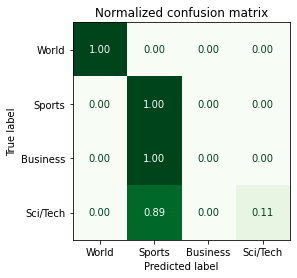

[[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.88888889 0.         0.11111111]]


In [228]:
cm = plot_confusion_matrix(y_true, y_pred, labels=label_names)

/Users/emiliomarinone/Personal_repos/divedeep-transformers/divedeep/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


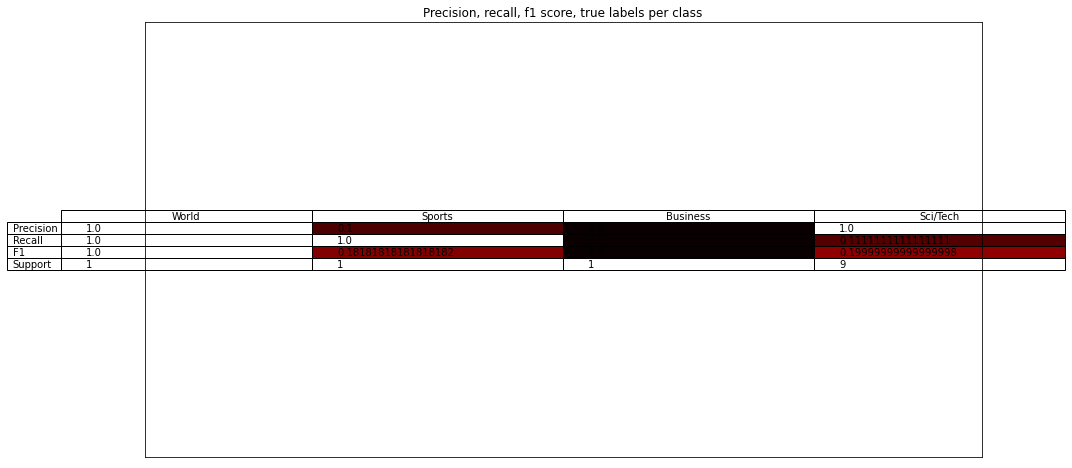

In [229]:
prfs = plot_prfs(y_true, y_pred, labels=label_names)